In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from keras.layers import Concatenate, Conv2D, Conv2DTranspose, Dense, Cropping2D, MaxPool2D, Input
from keras.models import Model, load_model

from tqdm import tqdm

### UNet for Image Segmentation

In [2]:
images_path = 'unet_dataset/images/'
mask_path = 'unet_dataset/mask/'
input_img_size = 256
num_images = 168
n_test_examples = 8
n_epochs = 10
learning_rate = 1E-5

TRAIN_MODEL = True

### Dataset Link

#### Link: [Google Drive](https://drive.google.com/file/d/1nenpWH4BdplSiHdfXs0oYfiA5qL42plB/view)

In [3]:
def num_parameters(layer, kernel_size, num_inp_channels, num_out_channels):
    if layer=='conv':
        return kernel_size * kernel_size * num_inp_channels * num_out_channels
    if layer=='pool':
        return 0

def get_cropping_dims(input_size, output_size):
    size_diff = input_size - output_size
    crop_val = int(size_diff/2)
    if size_diff % 2 == 0:
        return ((crop_val, crop_val), (crop_val, crop_val))
    else:
        return ((crop_val+1, crop_val), (crop_val+1, crop_val))
        
def deconv_output_size(input_dim, kernel_size, stride = 1, padding = 0):
    return (input_dim - 1) * stride + kernel_size - 2 * padding
    
def conv_output_size(input_dim, kernel_size, stride = 1, padding = 0):
    return (input_dim + 2 * padding - kernel_size) // stride + 1

def pool_output_size(input_dim, pool_size, stride = 1, padding = 0):
    return (input_dim + 2 * padding - pool_size) // stride + 1   

In [4]:
def get_output_dim(input_dim):
    x = conv_output_size(input_dim, 3)
    x1_l = conv_output_size(x, 3)

    x = pool_output_size(x1_l, 2, 2)
    x = conv_output_size(x, 3)
    x2_l = conv_output_size(x, 3)

    x = pool_output_size(x2_l, 2, 2)
    x = conv_output_size(x, 3)
    x3_l = conv_output_size(x, 3)

    x = pool_output_size(x3_l, 2, 2)
    x = conv_output_size(x, 3)
    x4_l = conv_output_size(x, 3)

    x = pool_output_size(x4_l, 2, 2)
    x = conv_output_size(x, 3)
    x = conv_output_size(x, 3)
    x4_r = deconv_output_size(x, 2, 2)

    x = conv_output_size(x4_r, 3)
    x = conv_output_size(x, 3)
    x3_r = deconv_output_size(x, 2, 2)

    x = conv_output_size(x3_r, 3)
    x = conv_output_size(x, 3)
    x2_r = deconv_output_size(x, 2, 2)

    x = conv_output_size(x2_r, 3)
    x = conv_output_size(x, 3)
    x1_r = deconv_output_size(x, 2, 2)

    x = conv_output_size(x1_r, 3)
    x = conv_output_size(x, 3)
    output_dim = deconv_output_size(x, 1, 1)
    print('Shapes: ', x1_l, x2_l, x3_l, x4_l, x4_r, x3_r, x2_r, x1_r, output_dim)
    return output_dim

In [5]:
input_dim = input_img_size
output_img_size = get_output_dim(input_dim)

assert output_img_size > 0, 'Invalid Input Size'

Shapes:  252 122 57 24 16 24 40 72 68


In [6]:
# contracting
inp = Input(shape=(input_img_size, input_img_size, 1))
x = Conv2D(64, kernel_size=(3,3), activation='relu')(inp)
x1_l = Conv2D(64, kernel_size=(3,3), activation='relu')(x)

x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x1_l)
x = Conv2D(128, kernel_size=(3,3), activation='relu')(x)
x2_l = Conv2D(128, kernel_size=(3,3), activation='relu')(x)

x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x2_l)
x = Conv2D(256, kernel_size=(3,3), activation='relu')(x)
x3_l = Conv2D(256, kernel_size=(3,3), activation='relu')(x)

x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x3_l)
x = Conv2D(512, kernel_size=(3,3), activation='relu')(x)
x4_l = Conv2D(512, kernel_size=(3,3), activation='relu')(x)

x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x4_l)
x = Conv2D(1024, kernel_size=(3,3), activation='relu')(x)

# expanding
x = Conv2D(1024, kernel_size=(3,3), activation='relu')(x)
x4_r = Conv2DTranspose(512, kernel_size=(2,2), strides=(2,2), activation='relu')(x)
x4_l_crop = Cropping2D(cropping=get_cropping_dims(x4_l.shape[1], x4_r.shape[1]))(x4_l)

x = Concatenate()([x4_l_crop, x4_r])
x = Conv2D(512, kernel_size=(3,3), activation='relu')(x)
x = Conv2D(512, kernel_size=(3,3), activation='relu')(x)
x3_r = Conv2DTranspose(256, kernel_size=(2,2), strides=(2,2), activation='relu')(x)
x3_l_crop = Cropping2D(cropping=get_cropping_dims(x3_l.shape[1], x3_r.shape[1]))(x3_l)

x = Concatenate()([x3_l_crop, x3_r])
x = Conv2D(256, kernel_size=(3,3), activation='relu')(x)
x = Conv2D(256, kernel_size=(3,3), activation='relu')(x)
x2_r = Conv2DTranspose(128, kernel_size=(2,2), strides=(2,2), activation='relu')(x)
x2_l_crop = Cropping2D(cropping=get_cropping_dims(x2_l.shape[1], x2_r.shape[1]))(x2_l)

x = Concatenate()([x2_l_crop, x2_r])
x = Conv2D(128, kernel_size=(3,3), activation='relu')(x)
x = Conv2D(128, kernel_size=(3,3), activation='relu')(x)
x1_r = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), activation='relu')(x)
x1_l_crop = Cropping2D(cropping=get_cropping_dims(x1_l.shape[1], x1_r.shape[1]))(x1_l)

x = Concatenate()([x1_l_crop, x1_r])
x = Conv2D(64, kernel_size=(3,3), activation='relu')(x)
x = Conv2D(64, kernel_size=(3,3), activation='relu')(x)
y = Conv2DTranspose(2, kernel_size=(1,1), strides=(1,1), activation='relu')(x)

model = Model(inputs = inp, outputs = y)
model.summary()

2022-03-26 14:02:01.351055: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 254, 254, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 252, 252, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [7]:
imgs = []
masks = []
for idx in tqdm(range(1, num_images+1)):
    image_file_path = images_path + f'building_{str(idx).zfill(3)}.tif'
    mask_file_path = mask_path + f'building_mask_{str(idx).zfill(3)}.tif'
    img = np.array(Image.open(image_file_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (input_img_size, input_img_size))

    mask = np.array(Image.open(mask_file_path)).astype('uint8')
    mask = cv2.resize(mask, (output_img_size, output_img_size))
    
    imgs.append(img)
    masks.append(mask)
    
imgs = np.array(imgs)    
masks = np.array(masks)
len(imgs), len(masks)

100%|██████████| 168/168 [00:01<00:00, 101.08it/s]


(168, 168)

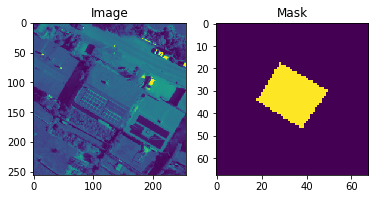

In [8]:
def plot_example(imgs, masks, idx, label1, label2):
    plt.subplot(121)
    plt.imshow(imgs[idx])
    plt.title(f'{label1}')

    plt.subplot(122)
    plt.imshow(masks[idx])
    plt.title(f'{label2}')
    plt.show()

idx = 34
plot_example(imgs, masks, idx, 'Image', 'Mask')

In [9]:
idxs = np.arange(num_images)
np.random.shuffle(idxs)

train_idxs = idxs[:-n_test_examples]
test_idxs = idxs[-n_test_examples:]

train_imgs = imgs[train_idxs]
train_masks = masks[train_idxs]
test_imgs = imgs[test_idxs]
test_masks = masks[test_idxs]

In [8]:
X = train_imgs
y = train_masks
X_test = test_imgs
y_test = test_masks

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model_name = f'model_unet_imgsize_{input_img_size}_epochs_{n_epochs}'
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

if TRAIN_MODEL:
    history = model.fit(X, y, epochs = n_epochs, shuffle = True, 
                        batch_size = 16, validation_split = 0.2, verbose=1)

    model.save(model_name)             

Epoch 1/10
8/8 [==============================] - 48s 6s/step - loss: 1.5104 - accuracy: 0.9029 - val_loss: 1.4761 - val_accuracy: 0.9043
Epoch 2/10
8/8 [==============================] - 48s 6s/step - loss: 1.4970 - accuracy: 0.9029 - val_loss: 1.4530 - val_accuracy: 0.9034
Epoch 3/10
8/8 [==============================] - 54s 7s/step - loss: 1.4464 - accuracy: 0.9005 - val_loss: 1.3237 - val_accuracy: 0.8960
Epoch 4/10
8/8 [==============================] - 54s 7s/step - loss: 0.9247 - accuracy: 0.8857 - val_loss: 0.6847 - val_accuracy: 0.8614
Epoch 5/10
8/8 [==============================] - 55s 7s/step - loss: 0.7013 - accuracy: 0.8545 - val_loss: 0.6877 - val_accuracy: 0.8415
Epoch 6/10
8/8 [==============================] - 57s 7s/step - loss: 0.6947 - accuracy: 0.8444 - val_loss: 0.6857 - val_accuracy: 0.8401
Epoch 7/10
8/8 [==============================] - 59s 7s/step - loss: 0.6907 - accuracy: 0.8487 - val_loss: 0.6822 - val_accuracy: 0.8520
Epoch 8/10
8/8 [==================

2022-03-22 21:54:50.992353: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_unet_imgsize_256_epochs_10/assets


In [9]:
model.save(model_name)

INFO:tensorflow:Assets written to: model_unet_imgsize_256_epochs_10/assets


In [10]:
def plotting(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title('Loss')
    plt.plot(range(1, n_epochs+1), train_loss, label = 'Train Loss')
    plt.plot(range(1, n_epochs+1), val_loss, label = 'Validation Loss')
    plt.legend()

    plt.subplot(122)
    plt.title('Accuracy')
    plt.plot(range(1, n_epochs+1), train_acc, label = 'Train Accuracy')
    plt.plot(range(1, n_epochs+1), val_acc, label = 'Validation Accuracy')
    plt.legend()
    plt.show()

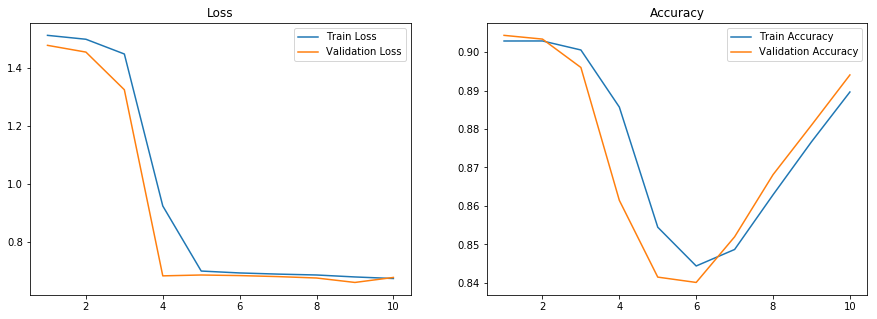

In [11]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plotting(train_loss, val_loss, train_acc, val_acc)

In [12]:
model = load_model(model_name)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=3)

In [ ]:
idx = 1
plot_example(y_test, y_pred, idx, 'GT', 'Prediction')